# Use map to generate tasks dynamically

The `active_map_zone` in WorkGraph is conceptually similar to Python's built-in map function. In WorkGraph, the `active_map_zone` spawns the tasks in the WorkGraph for each item in a dataset.

### Why use `active_map_zone`?

- **Creates dynamic tasks**: The number of tasks is determined at runtime based on input size.
- **Encapsulates child tasks**: All tasks inside a `active_map_zone` block are executed independently for each input item.

## Example: Running Tasks in Parallel with `active_map_zone`

Let's consider a simple workflow where we:
1. Generate a dictionary of numbers.
2. Add 1 to each number.
3. Multiply the result by 2.


In [1]:
from aiida_workgraph import task, WorkGraph, active_map_zone
from aiida import load_profile, orm

load_profile()

@task.calcfunction(outputs=["result"])
def generate_data(n: int) -> dict:
    """Generate a dictionary of integers."""
    result = {f"key_{i}": orm.Int(i) for i in range(n.value)}
    return {"result": result}

@task.calcfunction()
def add(x, y):
    return x + y

@task.calcfunction()
def multiply(x, y):
    return x * y

n = 3
with WorkGraph("map_example_1") as wg:
    data = generate_data(n=n)
    with active_map_zone(data) as map_zone:
        result = add(x=map_zone.item, y=1)
        result = multiply(x=result, y=2)

# Show the WorkGraph
wg.to_html()
# wg


### 🔹 What happens here?
- `active_map_zone` **automatically applies** the tasks (`add1` and `multiply2`) to **each element** in the dictionary output of `generate_data`.
- Each instance of `add1` and `multiply2` **runs independently and in parallel**.
- The `map_zone.item` is a special reference that **ensures each element is mapped correctly**.


### Running and Checking Results


In [2]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))

/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/querybuilder/main.py:182: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  result = build.query.count()
03/20/2025 07:36:50 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:50 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data1
03/20/2025 07:36:50 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|run_tasks]: Run task: generate_data1, type: CALCFUNCTION
/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/p

------------------------------------------------------------
kwargs:  {'n': <Int: uuid: 35fee10d-9307-4009-8a01-8b4eeb105734 (pk: 54723) value: 3>}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:36:50 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_task_state]: Task: generate_data1 finished.
03/20/2025 07:36:50 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:50 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: tasks ready to run: map_zone2
03/20/2025 07:36:50 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [

------------------------------------------------------------
kwargs:  {'source': AttributeDict({'key_0': <Int: uuid: b836838b-5565-4acf-8959-b9ff4bb24dce (pk: 54726) value: 0>, 'key_1': <Int: uuid: 37af63a6-2a85-48f1-87b8-f2844510d183 (pk: 54727) value: 1>, 'key_2': <Int: uuid: be80e285-1317-4a1a-bde9-cba50febde5f (pk: 54728) value: 2>}), 'placeholder': 'map_input'}


03/20/2025 07:36:51 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:51 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add3,key_1_add3,key_2_add3
03/20/2025 07:36:51 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|run_tasks]: Run task: key_0_add3, type: CALCFUNCTION
/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/backend.py:271: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed
  with session.begin_nested() as savepoint:


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: b836838b-5565-4acf-8959-b9ff4bb24dce (pk: 54726) value: 0>, 'y': 1}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_task_state]: Task: key_0_add3 finished.
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_multiply4,key_1_add3,key_2_add3
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.W

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 5128dcd1-1b40-40df-bb88-41533b41c28e (pk: 54731) value: 1>, 'y': 2}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_task_state]: Task: key_0_multiply4 finished.
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_add3,key_2_add3
03/20/2025 07:36:52 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNod

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 37af63a6-2a85-48f1-87b8-f2844510d183 (pk: 54727) value: 1>, 'y': 1}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_task_state]: Task: key_1_add3 finished.
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_multiply4,key_2_add3
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNod

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 92538e42-2bff-40a7-96b7-fcb309016b91 (pk: 54737) value: 2>, 'y': 2}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_task_state]: Task: key_1_multiply4 finished.
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_add3
03/20/2025 07:36:53 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT]

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: be80e285-1317-4a1a-bde9-cba50febde5f (pk: 54728) value: 2>, 'y': 1}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:36:54 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_task_state]: Task: key_2_add3 finished.
03/20/2025 07:36:54 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_template_task_state]: Task: add3 finished.
03/20/2025 07:36:54 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:36:54 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: edf4129e-7f57-427e-869e-941587b12f98 (pk: 54743) value: 3>, 'y': 2}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:36:55 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_task_state]: Task: key_2_multiply4 finished.
03/20/2025 07:36:55 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_template_task_state]: Task: multiply4 finished.
03/20/2025 07:36:55 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54724|WorkGraphEngine|update_zone_task_state]: Task: map_zone2 finished.
03/20/2025 07:36:55 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainN

State of WorkGraph:   FINISHED


Generate node graph from the AiiDA process:

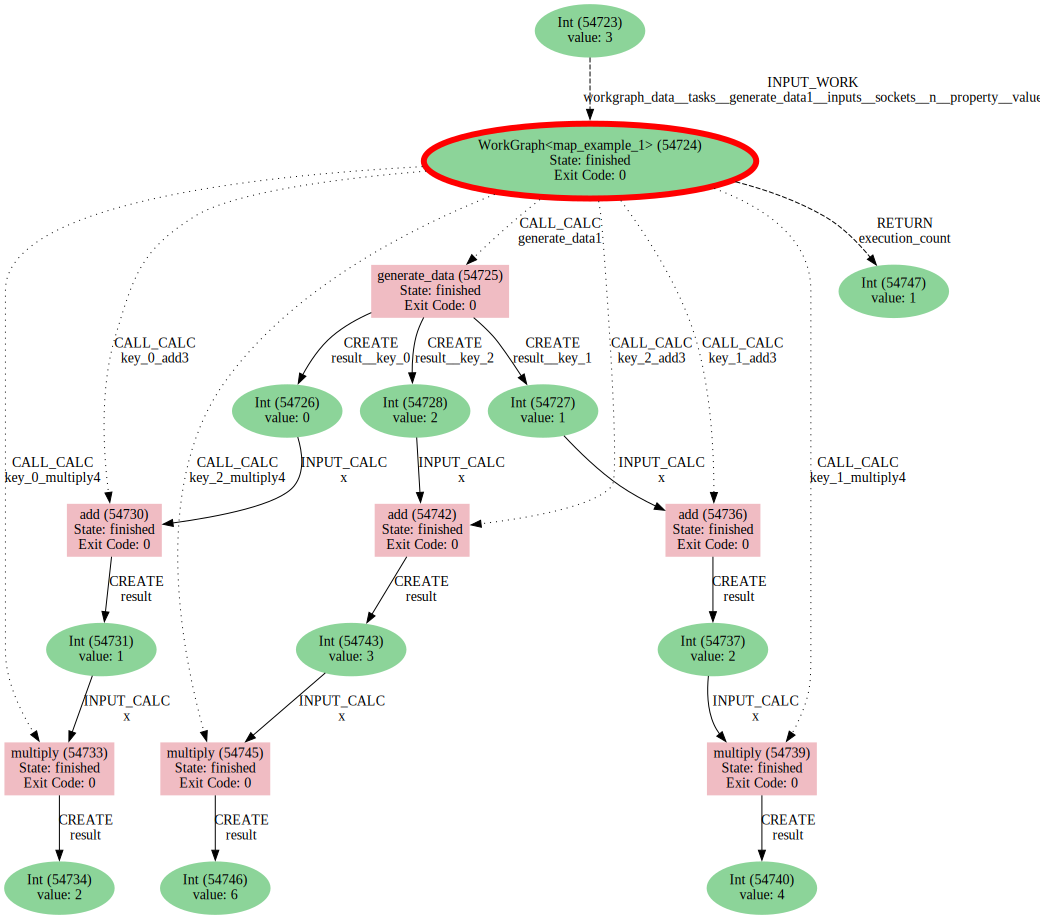

In [3]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Second workflow: gather results
Now I want to gather the results from the previous `multiply_parallel` tasks and calculate the sum of all their results.
Let's update the `multiply_parallel` function to `multiply_parallel_gather`.

In [10]:
@task.calcfunction()
def calc_sum(**datas) -> dict:
    """Compute the sum of all provided values."""
    return  sum(datas.values())

n = 3
with WorkGraph("map_example_1") as wg:
    data = generate_data(n=n)
    with active_map_zone(data) as map_zone:
        result = add(x=map_zone.item, y=1)
        result = multiply(x=result, y=2)
    total = calc_sum(datas=result)
wg.to_html()


Run the workgraph and get the result of the tasks:

In [11]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))
print('Result of task add1: {}'.format(total.value))

/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/querybuilder/main.py:182: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  result = build.query.count()
03/20/2025 07:41:19 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:19 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_data1
03/20/2025 07:41:19 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|run_tasks]: Run task: generate_data1, type: CALCFUNCTION
/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/p

------------------------------------------------------------
kwargs:  {'n': <Int: uuid: 32e62172-cc4a-47a5-9730-9a8e080ca5be (pk: 54802) value: 3>}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:20 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: generate_data1 finished.
03/20/2025 07:41:20 PM <1671614> aiida.orm.nodes.pro

------------------------------------------------------------
kwargs:  {'source': AttributeDict({'key_0': <Int: uuid: 9aed86b9-43ab-419b-b4a9-418e029d89d7 (pk: 54805) value: 0>, 'key_1': <Int: uuid: f92b56d4-402a-44bc-bbc1-676dfd3ea637 (pk: 54806) value: 1>, 'key_2': <Int: uuid: 0aed2635-95a3-4eb7-9c84-c11e5fccf04b (pk: 54807) value: 2>}), 'placeholder': 'map_input'}


03/20/2025 07:41:20 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:20 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_add3,key_1_add3,key_2_add3
03/20/2025 07:41:20 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|run_tasks]: Run task: key_0_add3, type: CALCFUNCTION
/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/backend.py:271: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed
  with session.begin_nested() as savepoint:


------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 9aed86b9-43ab-419b-b4a9-418e029d89d7 (pk: 54805) value: 0>, 'y': 1}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:21 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: key_0_add3 finished.
03/20/2025 07:41:21 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:21 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_0_multiply4,key_1_add3,key_2_add3
03/20/2025 07:41:21 PM <1671614> aiida.orm.nodes.process.workflow.workchain.W

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 60539860-08e1-4f11-a40d-dc7f62a5182b (pk: 54810) value: 1>, 'y': 2}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: key_0_multiply4 finished.
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_add3,key_2_add3
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNod

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: f92b56d4-402a-44bc-bbc1-676dfd3ea637 (pk: 54806) value: 1>, 'y': 1}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: key_1_add3 finished.
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_1_multiply4,key_2_add3
03/20/2025 07:41:22 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNod

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 18c845a1-8192-4cb9-a4ae-458ca8d8771c (pk: 54816) value: 2>, 'y': 2}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:23 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: key_1_multiply4 finished.
03/20/2025 07:41:23 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:23 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: tasks ready to run: key_2_add3
03/20/2025 07:41:23 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT]

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 0aed2635-95a3-4eb7-9c84-c11e5fccf04b (pk: 54807) value: 2>, 'y': 1}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:24 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: key_2_add3 finished.
03/20/2025 07:41:24 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_template_task_state]: Task: add3 finished.
03/20/2025 07:41:24 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:24 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803

------------------------------------------------------------
kwargs:  {'x': <Int: uuid: 7605a310-8f33-4918-8d70-3ffa1fa07d49 (pk: 54822) value: 3>, 'y': 2}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:25 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: key_2_multiply4 finished.
03/20/2025 07:41:25 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_template_task_state]: Task: multiply4 finished.
03/20/2025 07:41:25 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_zone_task_state]: Task: map_zone2 finished.
03/20/2025 07:41:25 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainN

------------------------------------------------------------
kwargs:  {}


/home/xing/apps/miniforge3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/utils.py:84: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)
  return getattr(self._model, item)
03/20/2025 07:41:26 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|update_task_state]: Task: calc_sum5 finished.
03/20/2025 07:41:26 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/20/2025 07:41:26 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/20/2025 07:41:26 PM <1671614> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [54803|WorkGrap

State of WorkGraph:   FINISHED
Result of task add1: uuid: 024da7ef-09f2-4761-ada9-70623a2acb31 (pk: 54827) value: 12


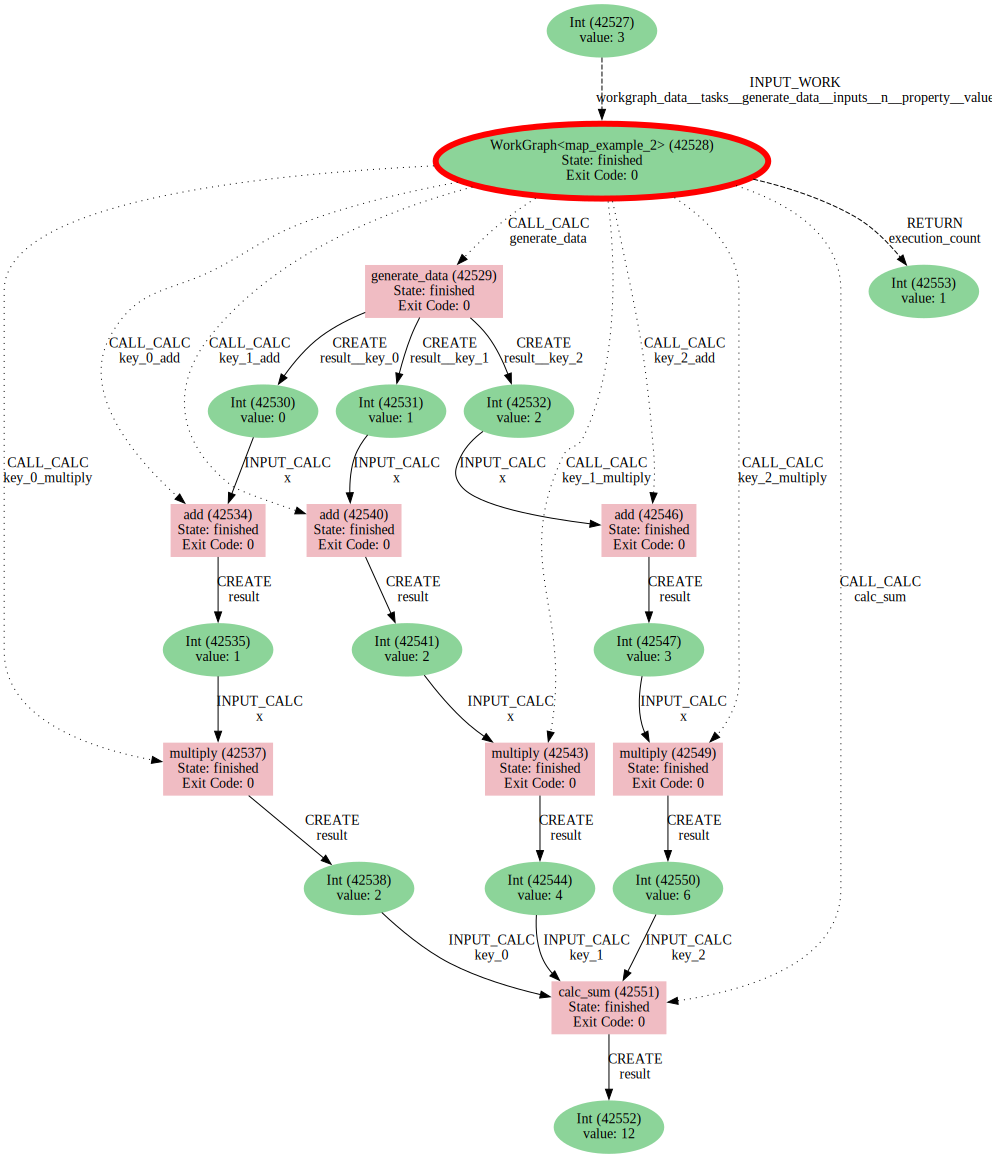

In [6]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

You can see that the outputs of all `add` tasks are linked to the input of the `calc_sum` task.